In [1]:
from langchain.globals import set_debug,set_verbose

In [ ]:
from langchain_aws import ChatBedrockConverse
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage
model_id = 'anthropic.claude-3-haiku-20240307-v1:0'
llm = ChatBedrockConverse(model=model_id,temperature=0)


In [3]:
from typing import List
def my_chat_bot(messages):
    system_message = SystemMessage("You are a customer support agent for an airline.")
    messages = [system_message] + messages
    output = llm.invoke(messages)
    return output

In [4]:
human_message = HumanMessage("hi")
output = my_chat_bot([human_message])
output

AIMessage(content='Hello! How can I assist you today?', response_metadata={'ResponseMetadata': {'RequestId': '5caf8116-ad3a-4753-a36f-c78a6b31a973', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 16 Jul 2024 06:53:44 GMT', 'content-type': 'application/json', 'content-length': '215', 'connection': 'keep-alive', 'x-amzn-requestid': '5caf8116-ad3a-4753-a36f-c78a6b31a973'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': 363}}, id='run-7eb8e413-e1ef-4d47-8295-34dd9aa32986-0', usage_metadata={'input_tokens': 18, 'output_tokens': 12, 'total_tokens': 30})

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

{instructions}

When you are finished with the conversation, respond with a single word 'FINISHED'"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_template),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

instructions = """Your name is Harrison. You are trying to get a refund for the trip you took to Alaska. \
You want them to give you ALL the money back. \
This trip happened 5 years ago."""

prompt = prompt.partial(instructions=instructions)

simulated_user = prompt | llm

In [7]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="Hello! How can I assist you today?")]
output = simulated_user.invoke({"messages": messages})
output

AIMessage(content="Hello, my name is Harrison. I'm calling about a trip I took to Alaska with your airline about 5 years ago. I would like to get a full refund for that trip.", response_metadata={'ResponseMetadata': {'RequestId': '6f2a3b9b-a23c-49c6-ab2b-a7d6317f3f87', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Tue, 16 Jul 2024 06:54:13 GMT', 'content-type': 'application/json', 'content-length': '338', 'connection': 'keep-alive', 'x-amzn-requestid': '6f2a3b9b-a23c-49c6-ab2b-a7d6317f3f87'}, 'RetryAttempts': 0}, 'stopReason': 'end_turn', 'metrics': {'latencyMs': 621}}, id='run-09060ae6-f252-480d-8134-a2f48a5228d9-0', usage_metadata={'input_tokens': 101, 'output_tokens': 43, 'total_tokens': 144})

In [8]:
from langchain_core.messages import AIMessage

def chat_bot_node(messages):
    # Call the chat bot
    chat_bot_response = my_chat_bot(messages)
    # Respond with an AI Message
    return AIMessage(content=chat_bot_response.content)

In [9]:
# start swapping from the 2nd message as the first message is only meant for the chatbot
def _swap_roles(messages):
    new_messages = []
    for m in messages[1:]:
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))
    return new_messages


def simulated_user_node(messages):
    # Swap roles of messages
    new_messages = _swap_roles(messages)
    # Call the simulated user
    response = simulated_user.invoke({"messages": new_messages})
    # This response is an AI message - we need to flip this to be a human message
    return HumanMessage(content=response.content)

In [10]:
def should_continue(messages):
    if len(messages) > 6:
        return "end"
    elif messages[-1].content == "FINISHED":
        return "end"
    else:
        return "continue"

In [11]:
from langgraph.graph import END, MessageGraph, START

graph_builder = MessageGraph()
graph_builder.add_node("user", simulated_user_node)
graph_builder.add_node("chat_bot", chat_bot_node)
# Every response from  your chat bot will automatically go to the
# simulated user
graph_builder.add_edge("chat_bot", "user")
graph_builder.add_conditional_edges(
    "user",
    should_continue,
    # If the finish criteria are met, we will stop the simulation,
    # otherwise, the virtual user's message will be sent to your chat bot
    {
        "end": END,
        "continue": "chat_bot",
    },
)
# The input will first go to your chat bot
graph_builder.add_edge(START, "chat_bot")
simulation = graph_builder.compile()

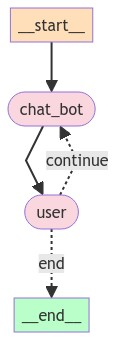

In [12]:
from IPython.display import Image, display
display(Image(simulation.get_graph(xray=True).draw_mermaid_png()))

In [13]:
human_message = HumanMessage("hi")
for chunk in simulation.stream([human_message]):
    for k, v in chunk.items():
        if k != "__end__":
            print('k',k)
            print('v',v)

k chat_bot
v content='Hello! How can I assist you today?'
k user
v content="Hello, my name is Harrison. I'm trying to get a refund for a trip I took to Alaska with your airline 5 years ago. I would like to get a full refund for the entire trip." id='0383ce22-1898-4829-a347-0fe1084fb67b'
k chat_bot
v content="I apologize, but I'm afraid I won't be able to process a refund for a trip that took place 5 years ago. Our standard refund policy only allows for refunds to be requested within 1 year of the original travel date.\n\nI understand you may have had extenuating circumstances, but our policies are in place to ensure fairness for all customers. Unfortunately, I do not have the ability to make exceptions to the 1-year refund window.\n\nI'd be happy to look into any other options that may be available to you, such as applying the value of your previous ticket towards a future booking. However, a full cash refund for a trip taken 5 years ago is not something I can process. Please let me kn